# Growth Rate Analysis with Bootstrap 

## import package

In [1]:
import sys;
import numpy as np;
import netCDF4 as nc;
import ChienKim as ck;

from itertools import product
from joblib import Parallel, delayed
from matplotlib import pyplot as plt

sys.path.append("/home/b11209013/Package/");
import Theory as th; #type: ignore
import DataProcess as dp; #type: ignore

## Load data

In [2]:
# dimension dictionary
dims: dict[str, np.ndarray] = dict();

# data dictionary
data: dict[str, np.ndarray] = dict();

# variable name list
var_list: list[str] = [
    "t", "q1",
    "lw", "sw", "cu"
]

exp = "CNTL"

with nc.Dataset(f"/work/b11209013/2024_Research/MPAS/PC/{exp}_PC.nc", "r") as f:
    for key in f.dimensions.items():
        dims[key[0]] = f.variables[key[0]][:];

    for key in var_list:
        data[key] = np.nansum(f.variables[key][:2], axis=0);
        
print(data.keys())

dict_keys(['t', 'q1', 'lw', 'sw', 'cu'])


## Processing data

### Symmetrizing data

In [3]:
fmt = dp.Format(dims["lat"])

data_sym: dict[str, np.ndarray] = dict();

for key in var_list:
    data_sym[key] = fmt.sym(data[key]).T;

data_sym["qr"] = data_sym["lw"] + data_sym["sw"]

var_list = data_sym.keys()

### Random Shuffle data 

In [4]:
# dictionary for shuffle data
data_shuffle: dict[str, np.ndarray] = dict();

# random object
for key in var_list:
    data_shuffle[key] = np.array([
        np.random.permutation(data_sym[key])
        for _ in range(500)
    ]);

### Windowing data

In [5]:
# hanning size
lsec: int = 120;

# hanning taper
hann: np.ndarray = np.hanning(120)[:, None];

# windowing original data
data_windowing: dict[str, dict[str, np.ndarray]] = dict(
    pc1 = dict(),
    pc2 = dict()
);

for key in var_list:
    data_windowing[key] = np.array([
        data_sym[key][i*60:i*60+120]
        for i in range(5)
    ]);

# windowing shuffled data
data_shuffle_windowing: dict[str, dict[str, np.ndarray]] = dict();


for key in var_list:
    data_shuffle_windowing[key] = np.array([
        data_shuffle[key][:, i*60:i*60+120]
        for i in range(5)
    ]).transpose((1, 0, 2, 3));

## Compute properties

In [6]:
# growth rate
sigma: dict[str, dict[str, np.ndarray]] = dict();

for key in var_list:
    if key != "t":
        sigma[key] = ck.Growth_Rate(data_windowing[key], data_windowing["t"]);
    else:
        continue;

# Coherence 
Coh2: dict[str, dict[str, np.ndarray]] = dict();

for key in var_list:
    if key != "t":
        Coh2[key] = ck.Coherence(
            data_windowing[key], data_windowing["t"]
        );
    else:
        continue;

# Shuffled Coherence Square
Coh2_shuffle: dict[str, dict[str, np.ndarray]] = dict();

def compute_coherence(i, data_key, data_t):
    # Make copies of the data to ensure they're writable
    return ck.Coherence(
        data_key[i].copy(), 
        data_t[i].copy()
    )

for key in var_list:
    if key == "t":
        continue
        
    Coh2_shuffle[key] = np.array(
        Parallel(n_jobs=-1)(
            delayed(compute_coherence)(
                i, 
                data_shuffle_windowing[key],
                data_shuffle_windowing["t"]
            )
            for i in range(500)
        )
    )

print(Coh2_shuffle["lw"].shape)

(500, 120, 720)


## Statistical test

### Z transform

In [7]:
def z_transform(coh2):
    r = np.sqrt(coh2)
    return np.log((1+r)/(1-r))

z_trans: dict[str, np.ndarray] = dict()

z_trans_shuffle: dict[str, np.ndarray] = dict()

for key in Coh2.keys():
    z_trans[key] = z_transform(Coh2[key])
    z_trans_shuffle[key] = z_transform(Coh2_shuffle[key])

### Z-test

In [8]:
upper_criteria: dict[str, np.ndarray] = dict()

for key in z_trans.keys():
    z_mean = z_trans[key].mean(axis=0)
    z_std  = z_trans_shuffle[key].mean(axis=0)
    
    upper_criteria[key] = z_mean + 2.33*z_std

### Test mask

In [9]:
sigma_masked: dict[str, np.ndarray] = dict()

for key in upper_criteria.keys():
    test_mask = np.where(z_trans[key] >= upper_criteria[key], 1, np.nan)

    sigma_masked[key] = sigma[key] * test_mask

## Plotting

### Plot setting

In [10]:
plt.rcParams.update({
    'font.size': 12,
    'figure.titlesize': 18,
    'axes.titlesize': 18,
    'axes.labelsize': 16,
    'font.family': 'serif',
})

wn = np.fft.fftshift(np.fft.fftfreq(720, d=1/720))
fr = np.fft.fftshift(np.fft.fftfreq(120, d=1/4))

fr_ana, wn_ana = th.genDispersionCurves(Ahe=[90, 25, 8])

e_cond = np.where(wn_ana[3, 0, :] < 0)[0]

### Plotting functions

#### PC 1

In [11]:
def plot_sigma(var):
    
    plt.figure(figsize=(8, 8))
    c1 = plt.contourf(
        wn, fr[fr > 0],
        np.fft.fftshift(sigma_masked[var])[fr > 0],
        levels=np.linspace(-8, 8, 17),
        cmap="BrBG_r",
        extend='both'
    )
    for i in range(3):
        plt.plot(
            wn_ana[3, i, e_cond],
            fr_ana[3, i, e_cond],
            color = 'k',
            linewidth=1,
            linestyle="--"
        )
        plt.plot(
            wn_ana[4, i, :],
            fr_ana[4, i, :],
            color = 'k',
            linewidth=1,
            linestyle="--"
        )
        plt.plot(
            wn_ana[5, i, :],
            fr_ana[5, i, :],
            color = 'k',
            linewidth=1,
            linestyle="--"
        )
    plt.xticks(np.linspace(-14, 14, 8))
    plt.yticks(np.linspace(0, 0.5, 6))
    plt.xlim(-15, 15)
    plt.ylim(0, 0.5)
    plt.xlabel('Zonal Wavenumber')
    plt.ylabel('Frequency [CPD]')
    plt.title(f'{exp} {var} EAPE Growth Rate')
    cb1 = plt.colorbar(
        c1, aspect=30, orientation='horizontal', label=r'$\sigma$ [day$^{-1}$]'
    )
    cb1.set_ticks(np.linspace(-8, 8, 9))
    plt.savefig(f'/home/b11209013/2024_Research/MPAS/GrowthRate/image/{exp}/{exp}_{var}.png', dpi=300)

### Plotting

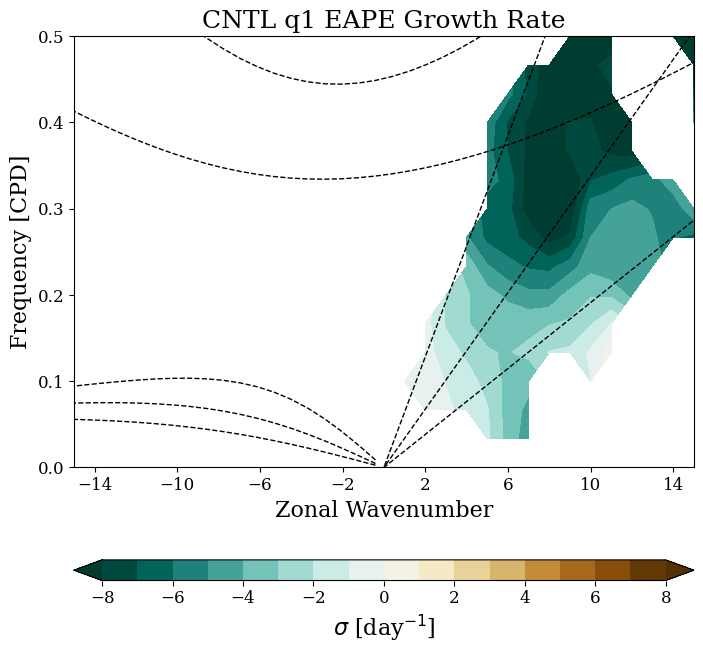

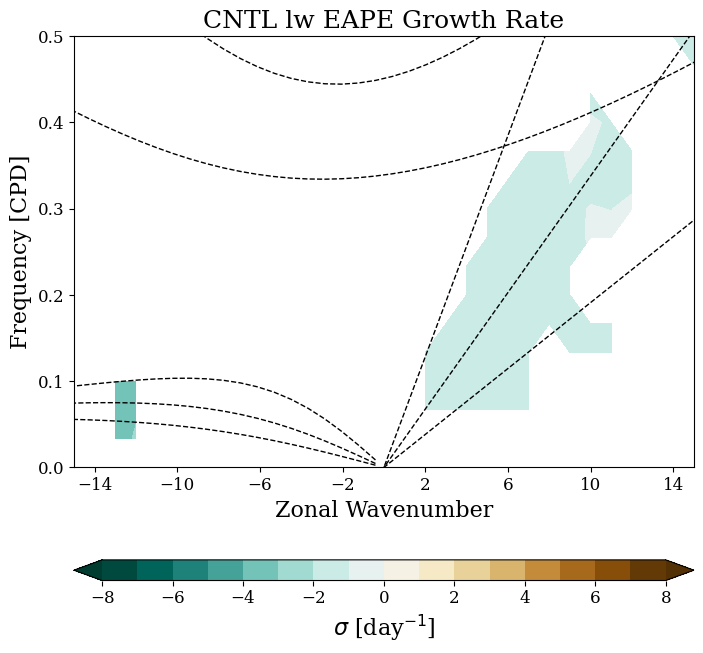

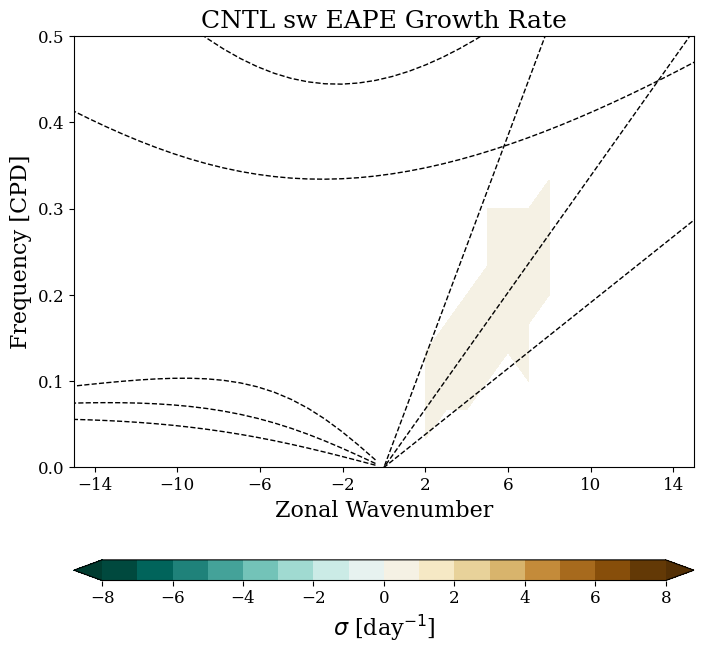

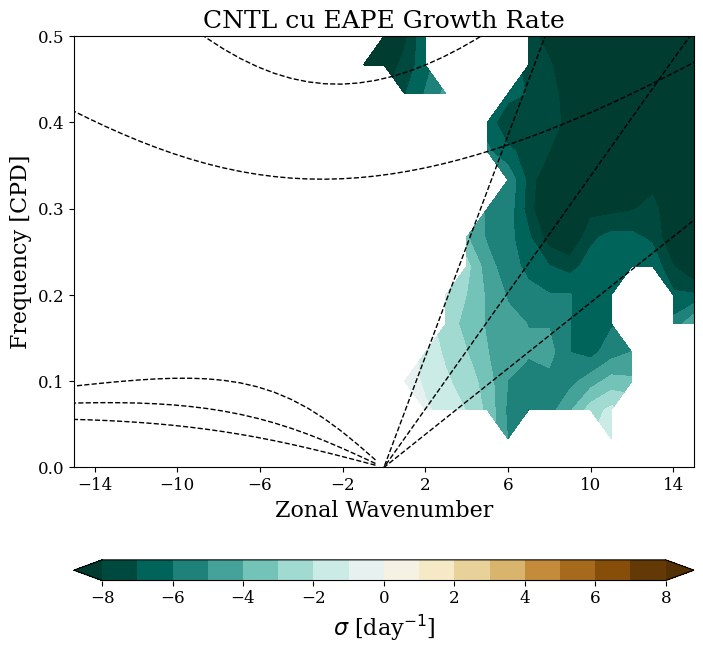

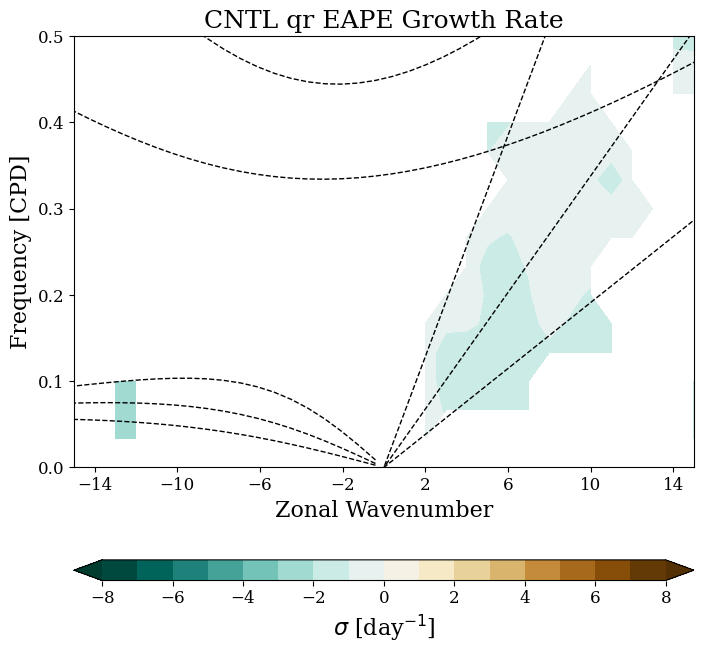

In [12]:
for var in sigma_masked.keys():
    plot_sigma(var)